In [1]:
from alpha_vantage.timeseries import TimeSeries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Utilize AlphaVantage API for stock data
api_key = '3ZFAN70PQ4CX2PTA'
ts = TimeSeries(key=api_key, output_format='pandas')

In [3]:
import ta

# Get daily time series for a stock
data, meta_data = ts.get_daily('MSFT', outputsize='full')

# Reverse the order of the dataframe so that dates are ascending
data = data.iloc[::-1]

# Reset index to make date a column
data.reset_index(inplace=True)
data.columns = ['date', 'open', 'high', 'low', 'close', 'volume']

# Include EMA
data['EMA10'] = ta.trend.ema_indicator(data['close'], window=10)

# Handle missing data
data.fillna(0, inplace=True)

# Split data
split_point = int(len(data) * 0.8)
train_data = data[:split_point]
test_data = data[split_point:]

# Use 'close' price and 'volume' for training
training_set = train_data[['close', 'volume', 'EMA10']].values
testing_set = test_data[['close', 'volume', 'EMA10']].values

In [4]:
print(data.isna().sum())
train_data.head()

date      0
open      0
high      0
low       0
close     0
volume    0
EMA10     0
dtype: int64


,date,open,high,low,close,volume,EMA10
0,1999-11-01,93.25,94.19,92.12,92.37,26630600.0,0.0
1,1999-11-02,92.75,94.50,91.94,92.56,23174500.0,0.0
2,1999-11-03,92.94,93.50,91.50,92.00,22258500.0,0.0
3,1999-11-04,92.31,92.75,90.31,91.75,27119700.0,0.0
4,1999-11-05,91.81,92.87,90.50,91.56,35083700.0,0.0


In [5]:
# Data Normalization: changing numeric values in dataset to a common scale
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [6]:
# Converting into 3D array for WEEKLY predictions
X_train = []
y_train = []
look_back = 20
look_ahead = 1

for i in range(look_back, len(training_set_scaled) - look_ahead):
    X_train.append(training_set_scaled[i - look_back:i, :])
    y_train.append(training_set_scaled[i + look_ahead, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

In [23]:
# Model initialization
model = Sequential([
    LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(units=75, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1)
])

# Model compilation
model.compile(optimizer='adam', loss='mean_squared_error')

# Model training
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0052 - val_loss: 0.0024
Epoch 2/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0011 - val_loss: 7.5876e-04
Epoch 3/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 9.5969e-04 - val_loss: 6.9647e-04
Epoch 4/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 9.8645e-04 - val_loss: 9.2273e-04
Epoch 5/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 9.1927e-04 - val_loss: 0.0068
Epoch 6/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 8.1900e-04 - val_loss: 0.0012
Epoch 7/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 6.8198e-04 - val_loss: 0.0014
Epoch 8/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 6.3564e-04 - val_loss: 2.7442e-04
Epoch 9/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 5.1098e-04 - val_loss: 9.6003e-04
Epoch 10/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 5.5505e-04 - val_loss: 5.9816e-04
Epoch 11/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 5.8518e-04 -

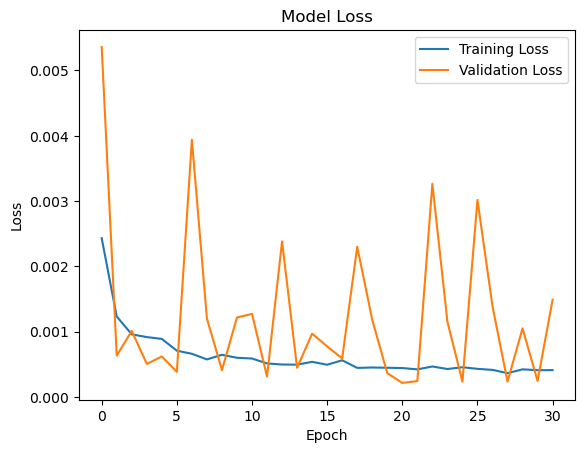

In [9]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
# Making predictions
X_test = []
y_test = []

# Using the last 60 days to predict the next day
for i in range(look_back, len(testing_set) - look_ahead):
    X_test.append(testing_set[i - look_back:i, :])  # Select all columns for the range of rows
    y_test.append(testing_set[i + look_ahead, 0])  # Only close price

X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape X_test
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Scale the input data
X_test_scaled = sc.transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test.shape)

# Make predictions
predicted_stock_price = model.predict(X_test_scaled)

# Inverse transform to get actual price values, add a dummy second feature to match the expected shape
predicted_stock_price = sc.inverse_transform(
    np.concatenate([predicted_stock_price, np.zeros((predicted_stock_price.shape[0], 2))], axis=1)
)[:, 0]

# y_test contains the actual prices for comparison
real_stock_price = y_test.reshape(-1, 1)

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


Mean Absolute Error: 35.91292601707619


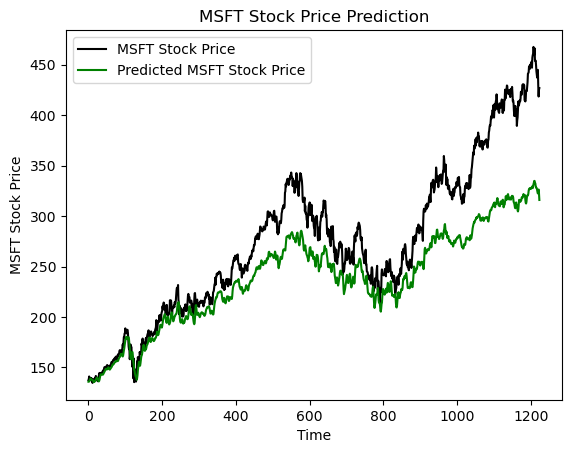

In [11]:
# Calculate Mean Absolute Error
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
print(f"Mean Absolute Error: {mae}")

# Plot the results
plt.plot(real_stock_price, color = 'black', label = 'MSFT Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted MSFT Stock Price')
plt.title('MSFT Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('MSFT Stock Price')
plt.legend()
plt.show()

In [25]:
# Save the model
model.save('financial_forecast_model.h5')